In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.weightstats import ztest
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, KFold, cross_val_score
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_regression, SelectFromModel
from scipy.stats import zscore
from sklearn.ensemble import StackingRegressor, VotingRegressor, RandomForestRegressor, BaggingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from pandas.plotting import scatter_matrix
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import plotly.io as pio
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance

In [27]:
class DataLoadMergePreprocess:
    def __init__(self, features_path='features.csv', stores_path='stores.csv', train_path='train.csv', test_path='test.csv', 
    selected_features=['Store', 'Dept', 'Type', 'Size', 'Week', 'Thanksgiving_Day']):
        self.features_path = features_path
        self.stores_path = stores_path
        self.train_path = train_path
        self.test_path = test_path
        self.selected_features = selected_features
        self.df = pd.DataFrame()
        self.test_data = pd.DataFrame()

    def load_merge_data(self):
        """
        Load and merge data from features, stores, and train CSV files into one dataframe.
        """
        # Load data from CSV files
        self.features = pd.read_csv(self.features_path)
        self.stores = pd.read_csv(self.stores_path)
        self.train = pd.read_csv(self.train_path)
        self.test = pd.read_csv(self.test_path)

        # Fill missing values in the 'MarkDown' columns with zeros
        MarkDown_column = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
        for column in MarkDown_column:
            median_value = self.features[column].median()
            self.features[column] = self.features[column].fillna(median_value)
        
        # Fill missing values in 'CPI' and 'Unemployment' columns with the last recorded non-null value
        other = ['CPI', 'Unemployment']
        for column in other:
            self.features[column] = self.features[column].fillna(method='ffill')

        # Merge the train, stores, and features dataframes based on common columns
        train_stores = pd.merge(self.train, self.stores, on='Store')
        test_stores = pd.merge(self.test, self.stores, on='Store')

        self.df = pd.merge(train_stores, self.features, on=['Store', 'Date', 'IsHoliday'])
        self.test_data = pd.merge(test_stores, self.features, on=['Store', 'Date', 'IsHoliday'])

    def preprocess(self, holiday_columns=True, encoding=True, outlier=True, scale_test=True, scale_split=True):
        if self.df is None:
            raise Exception("Data has not been loaded and merged yet.")
        
        if self.test_data is None:
            raise Exception("Data has not been loaded and merged yet.")

        # Stripping whitespace from column names
        self.df.columns = self.df.columns.str.strip()
        self.test_data.columns = self.test_data.columns.str.strip()

        # Transforming the date column into datetime and extracting all the needed features from the date column 
        self.df['Date'] = pd.to_datetime(self.df['Date']) 
        self.df['Week'] = self.df['Date'].dt.isocalendar().week.astype(int)
        self.df['Year'] = self.df['Date'].dt.year

        self.test_data['Date'] = pd.to_datetime(self.test_data['Date']) 
        self.test_data['Week'] = self.test_data['Date'].dt.isocalendar().week.astype(int)

        # Taking the absolute value of the target column 
        self.df['Weekly_Sales'] = self.df['Weekly_Sales'].abs().values

        if holiday_columns:
            # Extracting holiday names from IsHoliday column 
            self.df = self.add_holiday_columns(self.df)
            self.test_data = self.add_holiday_columns(self.test_data)

        self.df.sort_values(by='Date', ascending=True, inplace=True)
        self.df.set_index('Date', inplace=True)

        self.test_data.sort_values(by='Date', ascending=True, inplace=True)
        self.test_data.set_index('Date', inplace=True)

        if outlier:
            self.df = self.outlier_treatment(self.df)
            self.test_data = self.outlier_treatment(self.test_data)

        if encoding:
            self.df = self.encoding(self.df)
            self.test_data = self.encoding(self.test_data)

        if scale_split:
            self.X, self.y, self.X_train, self.X_test, self.y_train, self.y_test, self.scaler = self.split_scale(self.df)

        if scale_test:
            num_col=['Size','Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 
                                'MarkDown3', 'MarkDown4', 'MarkDown5','CPI','Unemployment']
            # scaler = StandardScaler().fit(self.X_train[num_col])
            self.test_data[num_col] = self.scaler.transform(self.test_data[num_col])

        if self.selected_features:
            self.test_data = self.test_data[self.selected_features]
            self.X = self.X[self.selected_features]
            self.X_train = self.X_train[self.selected_features]
            self.X_test = self.X_test[self.selected_features]

    def encoding(self, df, bool_col=['IsHoliday', 'Super_Bowl', 'Labour_Day', 'Thanksgiving_Day', 'Christmas'], 
                    cat_col='Type', bool_enc_type='numeric', cat_enc_type='numeric'):
        if self.df is None:
            raise Exception("Data has not been loaded and merged yet.")

        if bool_enc_type == 'numeric':
            df[bool_col] = np.where(df[bool_col] == True, 1, 0)
        elif bool_enc_type == 'onehotencode':
            df = pd.get_dummies(df, columns=[bool_col])
        elif bool_enc_type == 'labelencode':
            le = LabelEncoder()
            df[bool_col] = le.fit_transform(df[bool_col])
        else:
            raise ValueError("Invalid boolean encoding type. Please choose 'numeric', 'onehotencode', or 'labelencode'.")

        if cat_enc_type == 'numeric':
            df[cat_col] = np.where(df[cat_col] == 'A', 3, np.where(df[cat_col] == 'B', 2, 1))
        elif cat_enc_type == 'onehotencode':
            df = pd.get_dummies(df, columns=[cat_col])
        elif cat_enc_type == 'ordinalencode':
            oe = OrdinalEncoder()
            df[cat_col] = oe.fit_transform(df[cat_col])
        else:
            raise ValueError("Invalid categorical encoding type. Please choose 'numeric', 'onehotencode' or 'ordinalencode'.")
        return df

    def outlier_treatment(self, df):
        whisker_multiplier = 1.5
        col_num = ['Size','Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3','MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',]
        for column in col_num:
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_whisker = Q1 - whisker_multiplier * IQR
            upper_whisker = Q3 + whisker_multiplier * IQR

            df[column] = np.where(df[column] < lower_whisker, lower_whisker, df[column])
            df[column] = np.where(df[column] > upper_whisker, upper_whisker, df[column])

        return df

    def add_holiday_columns(self, df):
        if self.df is None:
            raise Exception("Data has not been loaded and merged yet.")
        
        # Extracting a column for each holiday that exist in IsHoliday column 
        Super_Bowl = pd.to_datetime(["2010-02-12", "2011-02-11", "2012-02-10", "2013-02-08"])
        Labour_Day = pd.to_datetime(["2010-09-10", "2011-09-09", "2012-09-07", ])
        Thanksgiving_Day = pd.to_datetime(["2010-11-26", "2011-11-25", '2012-11-23'])
        Christmas = pd.to_datetime(["2010-12-31", "2011-12-30", '2012-12-28'])
        df["Super_Bowl"] = df["Date"].isin(Super_Bowl)
        df["Labour_Day"] = df["Date"].isin(Labour_Day)
        df["Thanksgiving_Day"] = df["Date"].isin(Thanksgiving_Day)
        df["Christmas"] = df["Date"].isin(Christmas)
        return df
    
    def split_scale(self, df, scale=True, scaling_method='standard', year_train_start=2010, year_train_end=2012, year_test=2012):
        
        X_train = df[(df['Year']>=year_train_start) & (df['Year']<year_train_end)].drop('Weekly_Sales', axis=1)
        y_train = df[(df['Year']>=year_train_start) & (df['Year']<year_train_end)]['Weekly_Sales']

        X_test = df[df['Year']==year_test].drop('Weekly_Sales', axis=1)
        y_test = df[df['Year']==year_test]['Weekly_Sales']

        if scale:
            num_col=['Size','Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 
                                'MarkDown3', 'MarkDown4', 'MarkDown5','CPI','Unemployment']
            
            if scaling_method == 'minmax':
                scaler = MinMaxScaler()
            elif scaling_method == 'standard':
                scaler = StandardScaler()
            else:
                raise ValueError("Invalid scaling method. Please choose 'minmax' or 'standard'.")
            
            X_train[num_col] = scaler.fit_transform(X_train[num_col])
            X_test[num_col] = scaler.transform(X_test[num_col])
        
        return df.drop('Weekly_Sales', axis=1), df['Weekly_Sales'], X_train, X_test, y_train, y_test, scaler

        

## Loading and processsing the data ready for testing

In [28]:
data_processor = DataLoadMergePreprocess()
data_processor.load_merge_data()
data_processor.preprocess()

In [29]:
X_train, X_test, y_train, y_test = data_processor.X_train, data_processor.X_test, data_processor.y_train, data_processor.y_test
test_data_no_labels = data_processor.test_data

### Loading the models 

In [30]:
def model_load(file_name):
    with open(file_name, 'rb') as file:
        return joblib.load(file)

In [31]:
rf = model_load('RandomForest_model.joblib')
xgb = model_load('XGBRegressor_model.joblib')
cb = model_load('CatBoostRegressor_model.joblib')
sm = model_load('Stacked_model.joblib')

models = {'RandomForest':rf, 
          'XGBoost':xgb,
          'CatBoost':cb,
          'StackingRegression':sm}

### Model Evaluation

In [32]:
for name, model in models.items():
    print('-'*20)
    print(f'{name} Evaluation')
    print(f'R2 score for training data of {name}: {model.score(X_train, y_train)}')
    print(f'R2 score for testing data of {name}: {model.score(X_test, y_test)}')
    print(f'Mean Absolute error score for {name}: {mean_absolute_error(y_test, model.predict(X_test))}')

--------------------
RandomForest Evaluation
R2 score for training data of RandomForest: 0.9722920864671593
R2 score for testing data of RandomForest: 0.9612068430167814
Mean Absolute error score for RandomForest: 2264.9083468546683
--------------------
XGBoost Evaluation
R2 score for training data of XGBoost: 0.948074451685192
R2 score for testing data of XGBoost: 0.9455679333285798
Mean Absolute error score for XGBoost: 3063.3751180348117
--------------------
CatBoost Evaluation
R2 score for training data of CatBoost: 0.9696453537237703
R2 score for testing data of CatBoost: 0.9602074074282643
Mean Absolute error score for CatBoost: 2591.3319105548103
--------------------
StackingRegression Evaluation
R2 score for training data of StackingRegression: 0.9736452471818186
R2 score for testing data of StackingRegression: 0.9639012069142776
Mean Absolute error score for StackingRegression: 2143.784589362104


### Predicting and ploting the results

In [35]:
def predict_plot(y_train, X_test, y_test, reg, test_data, name):
    y_pred = reg.predict(X_test)
    y_pred = pd.DataFrame(y_pred, index=X_test.index, columns=['Prediction'])

    y_pred_new = reg.predict(test_data)
    y_pred_new = pd.DataFrame(y_pred_new, index=test_data.index, columns=['Prediction'])

    plt.figure(figsize=(20, 6))
    plt.title(f'Prediction of Weekly Sales using {name}', fontsize=20)
    plt.plot(y_train.resample('W').mean(), label='Training data')
    plt.plot(y_test.resample('W').mean(), label='Test data with target')
    plt.plot(y_pred_new.resample('W').mean(), label='Prediction of test data without target')
    plt.plot(y_pred.resample('W').mean(), label='Prediction of test data with target')
    plt.legend(loc='best')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Weekly Sales', fontsize=14)
    plt.show()
    return y_pred.resample('W').mean(), y_pred_new.resample('W').mean()


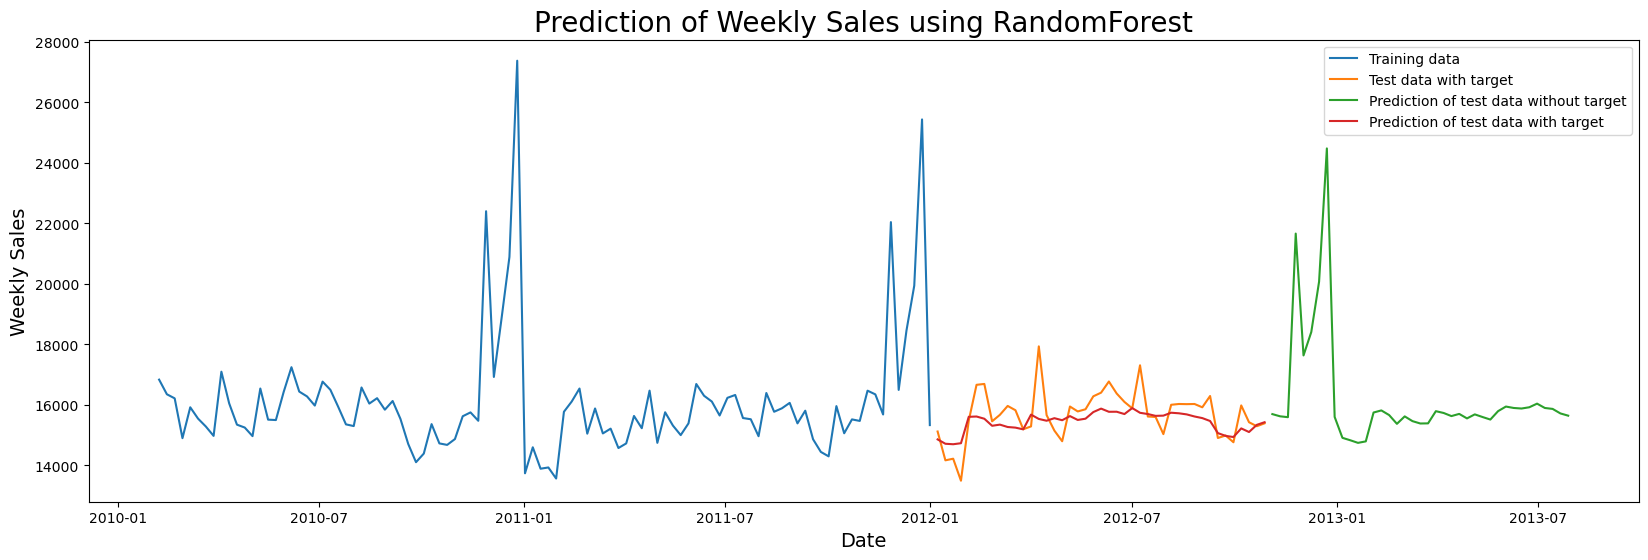

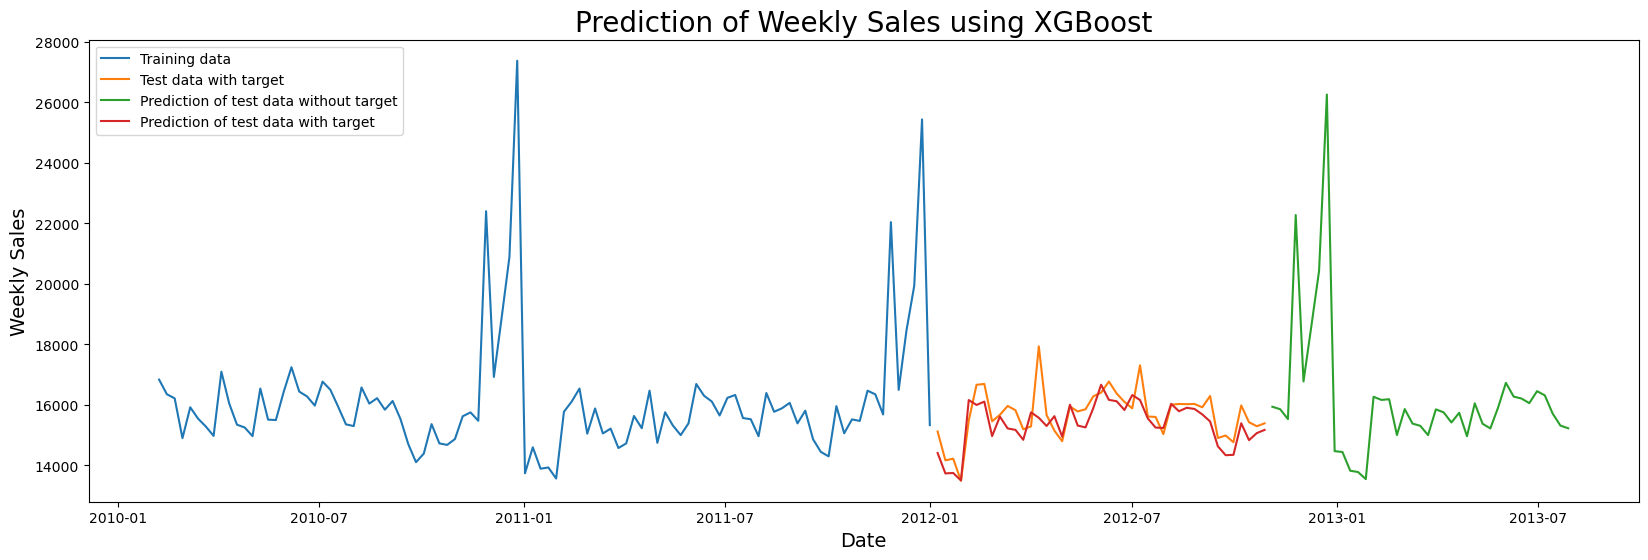

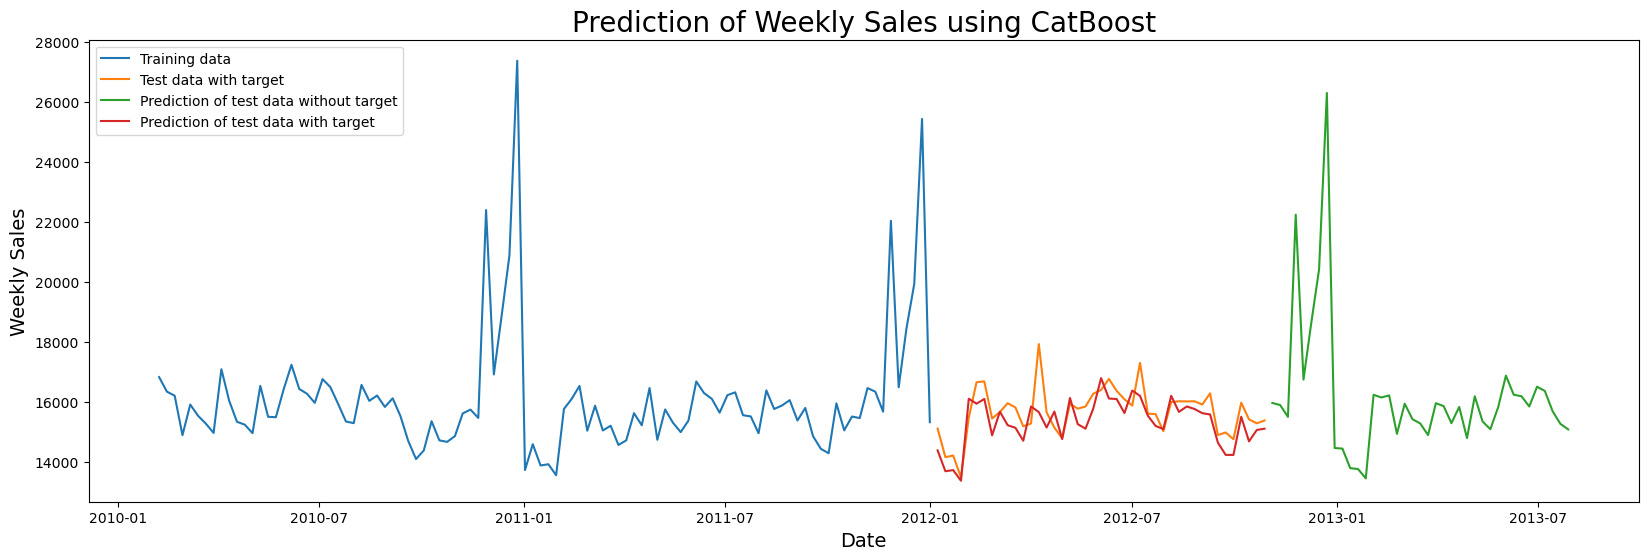

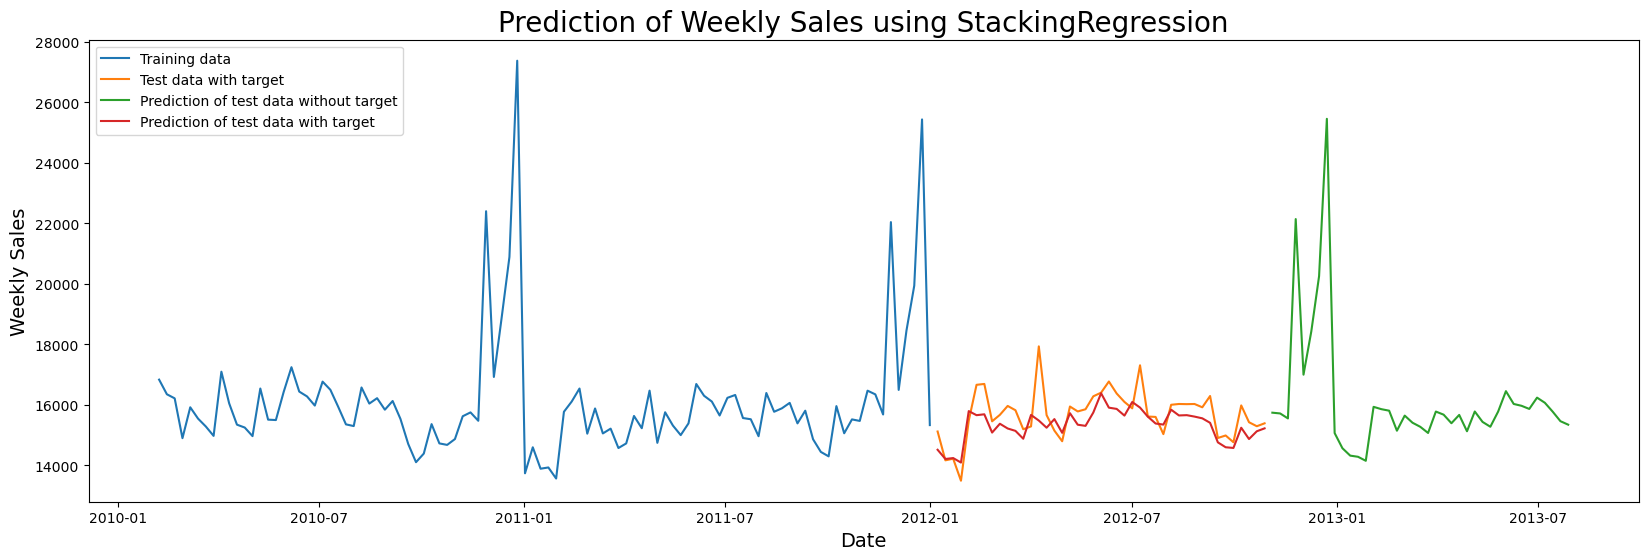

In [36]:
for name, model in models.items():
    predict_plot(y_train, X_test, y_test, model, test_data_no_labels, name)